# Organize FB posts for Maria
In which we organize all the FB posts that we've collected from groups related to Hurricane Maria.

In [2]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

## Load all statuses
Start with statuses, and we can add comments later if we need more data.

In [ ]:
import re
status_dir = '../../data/facebook-maria/'
status_file_matcher = re.compile('.*_posts.tsv')
status_files = [os.path.join(status_dir, f) for f in os.listdir(status_dir) if status_file_matcher.match(f)]
print(status_files)

In [21]:
status_df_list = [pd.read_csv(f, sep='\t', index_col='status_id') for f in status_files]
status_df = pd.concat(status_df_list, axis=0)
print('%d total statuses'%(status_df.shape[0]))
print(status_df.head())

14243 total statuses
                                                                    status_message  \
status_id                                                                            
171400810082867_179943782561903                                                NaN   
171400810082867_179449189278029  Cuales son Los pueblos que tiene luz y gas en ...   
171400810082867_179816299241318                                                NaN   
171400810082867_173145186575096  Mis hermanos del Oeste. Aguanten y no se me ri...   
171400810082867_173300749892873  Orgullosa de llamar a este grupo mi familia! V...   

                                    status_author link_name status_type  \
status_id                                                                 
171400810082867_179943782561903   Luz Marie Pagan       NaN       photo   
171400810082867_179449189278029  Juanita Berrocal       NaN      status   
171400810082867_179816299241318      Tita L. Ruiz    Millie       photo   
1

## NER tagging
How many of these statuses contain references to locations? Let's find out!!

In [10]:
from nltk.tag import StanfordNERTagger
stanford_dir = 'stanford-ner-2017-06-09/'
jar_file = os.path.join(stanford_dir, 'stanford-ner-3.8.0.jar')
model_file = os.path.join(stanford_dir, 'classifiers/spanish.ancora.distsim.s512.crf.ser.gz')
tagger = StanfordNERTagger(model_filename=model_file, path_to_jar=jar_file)

/hg190/istewart6/crisis_language/lib/python2.7/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [13]:
test = 'Vi a fidel castro en la playa'
test_tags = tagger.tag(test.split(' '))
print(test_tags)

[(u'Vi', u'O'), (u'a', u'O'), (u'fidel', u'PERS'), (u'castro', u'PERS'), (u'en', u'O'), (u'la', u'O'), (u'playa', u'O')]


It works! But really slowly.

In [19]:
import timeit
%timeit -n 10 tagger.tag(test.split(' '))

10 loops, best of 3: 1.63 s per loop


Can we shift the tagging to bash? I think that will be faster.

First write only text and index to file, then tag, then read back in.

In [28]:
from itertools import izip
import codecs
def write_txt_to_file(txt_series, file_name):
    """
    Write each line of text and its index to file.
    
    Parameters:
    -----------
    txt_series : pandas.Series
    file_name : str
    """
    N = txt_series.index.max()
    txt_series.sort_index(inplace=True)
    with codecs.open(file_name, 'w', encoding='utf-8') as file_output:
        for i, l in izip(txt_series.index, txt_series):
            # need to include index to original dataframe
            l_clean = l.decode('utf-8').replace('\n', '')
            file_output.write('INDEX%s\t%s'%(i, l_clean))
            # add line break for every line except the last
            if(i < N):
                file_output.write('\n')

In [29]:
status_df_txt = status_df.loc[:, 'status_message'].dropna(inplace=False)
out_file_name = '../../data/facebook-maria/combined_group_statuses.txt'
write_txt_to_file(status_df_txt, out_file_name)

Outside of notebook: ran

    bash tag_spanish_txt.sh

In [34]:
# need to clean up the tags
# because there were some spaces inserted randomly
def clean_txt(txt_lines):
    """
    Clean the irregular spacing in text lines by
    using the index markers as line anchors.
    
    Parameters:
    -----------
    txt_lines : [str]
    
    Returns:
    --------
    fixed_txt : [str]
    """
    curr_txt = ''
    fixed_txt = []
    index_matcher = re.compile('(?<=INDEX)[0-9_]+')
    for l in txt_lines:
        l = l.replace('\t', ' ')
        for t in l.split(' '):
            index_match = index_matcher.findall(t)
            if(len(index_match) > 0):
                index_match = index_match[0]
                if(curr_txt != ''):
                    fixed_txt.append(curr_txt)
                    curr_txt = index_match + '\t'
                else:
                    curr_txt = index_match + '\t'
            else:
                curr_txt += t + ' '
    # cleanup
    fixed_txt.append(curr_txt)
    return fixed_txt

In [35]:
tagged_file_name = '../../data/facebook-maria/combined_group_statuses_ner.txt'
status_df_txt_tagged = [l.strip() for l in codecs.open(tagged_file_name, encoding='utf-8')]
status_df_txt_tagged = clean_txt(status_df_txt_tagged)
print('\n'.join(status_df_txt_tagged[:10]))

130913387550000_130915504216455	Saludos/O :/O han/O tenido/O comunicación/O con/O alguien/O en/O Yabucoa/LUG ??/O No/O sé/O nada/O de/O mi/O tía/O q/O vive/O en/O Jardines/OTROS .../O ./O 
130913387550000_130915764216429	Gente/O vamos/O a/O ver/O si/O podemos/O usar/O esto/O para/O el/O beneficio/O de/O todos/O con/O familiares/O en/O Yabucoa/LUG ./O 
130913387550000_130915814216424	Le/O postearon/O esto/O al/O hermano/O de/O Heriberto/PERS está/O pidiendo/O prestado/O un/O fourtrack/O para/O ir/O de/O Juncos/OTROS a/O Yabucoa/LUG el/O desespero/O ya/O es/O mucho/O 
130913387550000_130916214216384	Buenas/O hablo/O desde/O Boston/LUG Massachusetts/LUG ./O Quisiera/O saber/O cualquier/O información/O que/O tenga/O de/O Camino/OTROS Nuevo/OTROS ./O Mi/O padre/O es/O Pedro/PERS Cruz/PERS Rivera/PERS y/O Mi/O tia/O es/O Zoraida/PERS Melendez/PERS Figueroa/PERS policía/O de/O Municipio/OTROS de/O Yabucoa/LUG ./O Por/O favor/O cualquier/O cosa/O que/O sepan/O de/O mi/O pueblo/O es/O un/O agra

In [51]:
status_df_txt_tagged = pd.Series(dict(((t.split('\t')[0], t.split('\t')[1]) for t in status_df_txt_tagged)))

Count the entities!

In [85]:
def collect_entities_from_txt(txt, include_type=False):
    """
    Collect entity strings from text. NOTE: we assume
    that all adjacent strings tagged as "ENTITY" form
    part of the same entity, which is obviously not true
    for some cases, e.g., "the hurricane hit Puerto/ENT Rico/ENT, Guadelupe/ENT..."
    
    Parameters
    ----------
    txt : str
    
    Returns:
    --------
    entity_list : list
    """
    tokens = txt.strip().split(' ')
    entity_list = []
    entity_str = []
    outside_tag = 'O'
    for t in tokens:
        # split into text and tag
        t_pieces = t.split('/')
        t_txt = '/'.join(t_pieces[:-1])
        t_tag = t_pieces[-1]
        # build up entity string
        if(t_tag != outside_tag):
            if(include_type):
                entity_str.append(t)
            else:
                entity_str.append(t_txt)
        # store and reset entity string
        elif(len(entity_str) > 0):
            if(include_type):
                entity_type = entity_str[-1].split('/')[1]
                entity_str = '_'.join(map(lambda x: x.split('/')[0], entity_str))
                entity_list.append('%s/%s'%(entity_str, entity_type))
            else:
                entity_list.append('_'.join(entity_str))
            entity_str = []
    return entity_list

In [82]:
from collections import Counter
status_entities = map(collect_entities_from_txt, status_df_txt_tagged.values)
status_entity_counts = Counter(reduce(lambda x,y: x+y, status_entities))

In [54]:
print(u'Mayag\xfcez')

Mayagüez


In [83]:
top_k = 100
status_entity_counts_top_k = status_entity_counts.most_common(top_k)
print("top %d most common entities:"%(top_k))
print('\n'.join(map(lambda x: '%s,%d'%(x[0].encode('utf-8'), x[1]), status_entity_counts_top_k)))

top 100 most common entities:
Puerto_Rico,816
PR,463
Dios,407
Coamo,406
Ponce,329
Yabucoa,262
Carr,252
Corozal,213
Gracias,200
Alguien,178
Urb,144
Hola,132
San_Juan,117
Maria,112
Aguadilla,97
FEMA,91
Naranjito,83
I,80
Florida,80
Mayaguez,80
Walmart,71
Arecibo,71
Please,68
Humacao,64
Jardines,62
Isla,62
Estados_Unidos,59
Moca,55
Cabo_Rojo,53
Llanos,52
Palmarejo,51
Centro,51
Any,50
Facebook,48
Quebradillas,48
Esc,47
María,47
Guayama,43
Orlando,43
Aguada,42
Isabela,41
Añasco,40
Ceiba,39
Bendiciones,38
Centro_Comunal,37
Mayagüez,37
Barrio,37
Caguas,37
Guaynabo,36
Zello,36
USA,36
Departamento,36
fam,36
Pueblo,35
Boricua,35
Parque,34
Villa_Madrid,33
Santa_Ana,32
Fajardo,32
Yauco,32
San_Sebastián,32
COAMO,32
Familia,32
I_am,31
If,31
Informacion,31
EmergenciasHatillo,30
it,30
Porfavor,30
Lares,30
but,30
Bayamón,30
Calle,29
Naguabo,29
Bendiga,28
Jesus,28
Plaza,28
Miami,28
Bayamon,27
Santa_Isabel,27
Lajas,27
Carretera,27
They,26
Utuado,26
Piedras_Blancas,26
Piedras,26
Cayey,26
Hurricane_Maria,26

Entity versus non-entity stats:

Precision = 82/100 = 82%

It seems like common words (`If`, `I`, `SHARE`) get mistagged as entities, but on the whole everything else looks OK. I do wonder if this means that the long tail of entities is also mistagged.

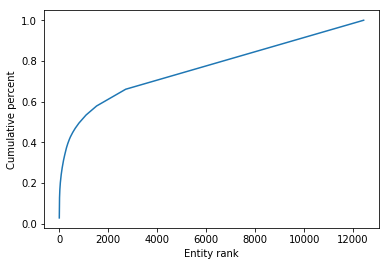

In [62]:
from __future__ import division
# get plot of rank and cumulative probability
status_entity_counts = pd.Series(status_entity_counts)
entity_ranks = pd.np.arange(len(status_entity_counts))
entity_pct = status_entity_counts.sort_values(inplace=False, ascending=False).cumsum() / status_entity_counts.sum()
plt.plot(entity_ranks, entity_pct)
plt.xlabel('Entity rank')
plt.ylabel('Cumulative percent')
plt.show()

Yup! The top 2000 entities make up 60% of the data, and from there it's basically one-off entities. Still could be a good amount of ambiguity!

## Per-post statistics

1. What fraction of the posts contain at least one entity mention?
2. What fraction of the posts contain at least one location mention?

In [65]:
print(status_entities[:10])

[[u'Yabucoa', u'Jardines'], [u'Yabucoa'], [u'Heriberto', u'Juncos', u'Yabucoa'], [u'Boston_Massachusetts', u'Camino_Nuevo', u'Pedro_Cruz_Rivera', u'Zoraida_Melendez_Figueroa', u'Municipio', u'Yabucoa'], [u'Wapa', u'Yabucoa'], [u'Luz_Mej\xedas', u'Mej\xedas', u'Yabucoa'], [], [], [], [u'Yabucoa', u'Wapa', u'CDT']]


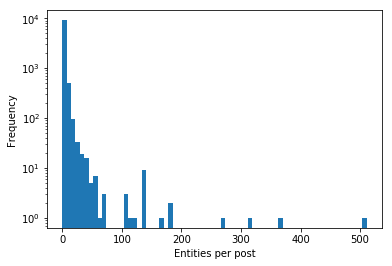

In [72]:
entity_counts = pd.Series(map(len, status_entities))
bins = entity_counts.nunique()
plt.hist(entity_counts, bins=bins)
plt.xlabel("Entities per post")
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In [92]:
at_least_one_entity_pct = len(entity_counts[entity_counts > 0]) / len(entity_counts) * 100
print('%.3f%% of posts have at least one entity'%(at_least_one_entity_pct))

67.904% of posts have at least one entity


Also, how is it possible for a post to have more than 100 entities??

In [74]:
# get example posts
high_entity_cutoff = 100
high_entity_post_indices = [i for i, s in enumerate(status_entities) if len(s) > high_entity_cutoff]
high_entity_status_txt = [status_df_txt_tagged[i] for i in high_entity_post_indices]
print(high_entity_status_txt[0])

Buenas/O noticias/O !!!/O GENTE/O EN/O 🇵🇷/O 🇵🇷/O 🇵🇷/O Pongalo/PERS en/O sus/O status/O para/O que/O su/O familia/O sepa/O donde/O buscar/O provisiones!LISTA/O DE/O OASISOasis/LUG Región/LUG Metro/LUG :/O Bayamón/LUG --/O Carr/PERS ./O 829/O ,/O entrada/O a/O Collores/PERS ,/O Urb/ORG ./O Santa/O OlayaBayamón/O --/O Ave./O Santa/PERS Juanita/PERS ,/O Esquina/ORG Hostos/ORG ,/O frente/O Funeraria/O AsencioBayamón/O --/O Al/O final/O Ave./O Irlanda/ORG Height/ORG ,/O calle/O Palestina/LUG ,/O Santa/LUG JuanitaTrujillo/LUG Alto/LUG --/O Calle/OTROS José/OTROS de/O Diego/OTROS ,/O Escorial/ORG Shopping/ORG Center/ORG ,/O detrás/O del/O Home/ORG DepotTrujillo/ORG Alto/ORG --/O PR/ORG 843/ORG ,/O Km/O 3.5/O frente/O a/O Urb/ORG ./O Villas/O de/O CarraízoCarolina/LUG --/O Carr/PERS ./O 845/O ,/O Ave./O Montecarlo/PERS ,/O frente/O a/O Portal/PERS de/O la/O ReinaGuaynabo/O --/O Carr/PERS ./O 833/O ,/O Int/ORG ./O Centros/O de/O Servicios/OTROS Múltiples/O GuaraguaoGuaynabo/O --/O Expreso/O 852/

OK! So some of these posts are extremely long, which is the opposite problem from Twitter.

Next question: how many posts contain a location reference?

In [86]:
status_type_entities = map(lambda x: collect_entities_from_txt(x, include_type=True), status_df_txt_tagged.values)
status_type_entity_counts = Counter(reduce(lambda x,y: x+y, status_type_entities))
top_k = 100
status_entity_counts_top_k = status_type_entity_counts.most_common(top_k)
print("top %d most common entities:"%(top_k))
print('\n'.join(map(lambda x: '%s,%d'%(x[0].encode('utf-8'), x[1]), status_entity_counts_top_k)))

top 100 most common entities:
Puerto_Rico/LUG,810
PR/ORG,463
Coamo/LUG,374
Yabucoa/LUG,250
Dios/PERS,249
Carr/PERS,232
Gracias/OTROS,199
Ponce/PERS,198
Alguien/ORG,160
Dios/OTROS,156
Urb/ORG,141
Hola/ORG,122
Maria/PERS,111
Corozal/LUG,99
Aguadilla/LUG,97
Corozal/ORG,96
Ponce/LUG,93
FEMA/ORG,91
San_Juan/LUG,81
Florida/LUG,80
Naranjito/LUG,79
I/OTROS,74
Walmart/ORG,70
Mayaguez/LUG,61
Jardines/OTROS,61
Humacao/LUG,53
Arecibo/LUG,52
Isla/LUG,49
Estados_Unidos/LUG,49
Quebradillas/LUG,48
Facebook/ORG,48
Palmarejo/LUG,48
María/PERS,46
Please/ORG,45
Guayama/LUG,43
Orlando/LUG,41
Isabela/LUG,41
Llanos/LUG,40
Centro/ORG,37
Mayagüez/LUG,36
fam/ORG,36
Ponce/OTROS,36
Centro_Comunal/ORG,35
Caguas/LUG,35
Guaynabo/LUG,34
Any/PERS,34
Boricua/OTROS,34
Pueblo/OTROS,33
Departamento/ORG,32
Bendiciones/PERS,32
Aguada/LUG,31
Añasco/PERS,31
Fajardo/PERS,30
Bayamón/LUG,30
EmergenciasHatillo/OTROS,30
Esc/PERS,29
If/ORG,29
Yauco/LUG,29
Barrio/LUG,28
Miami/LUG,28
but/ORG,28
Lares/PERS,27
I_am/ORG,27
Villa_Madrid/

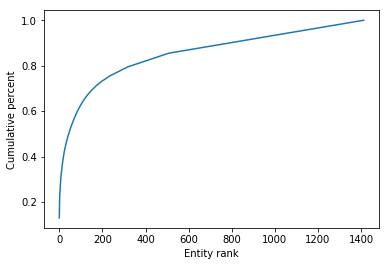

In [93]:
location_tag = 'LUG'
status_type_location_counts = {k : v for k,v in status_type_entity_counts.iteritems() if k.split('/')[-1] == location_tag}
status_type_location_counts = pd.Series(status_type_location_counts)
entity_ranks = pd.np.arange(len(status_type_location_counts))
entity_pct = status_type_location_counts.sort_values(inplace=False, ascending=False).cumsum() / status_type_location_counts.sum()
plt.plot(entity_ranks, entity_pct)
plt.xlabel('Entity rank')
plt.ylabel('Cumulative percent')
plt.show()

Top 200 locations comprise 60% of location mentions.

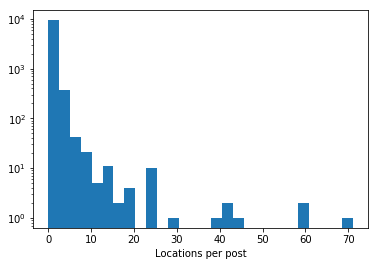

In [90]:
location_tag = 'LUG'
location_counts = pd.Series([len(filter(lambda x: x.split('/')[-1] == location_tag, e)) for e in status_type_entities])
plt.hist(location_counts, bins=location_counts.nunique())
plt.xlabel('Locations per post')
plt.yscale('log')
plt.show()

Most posts have no location, only a few posts with many locations.

In [91]:
at_least_one_location_pct = len(location_counts[location_counts > 0]) / len(location_counts) * 100
print('%.3f%% of posts contain at least one location'%(at_least_one_location_pct))

33.998% of posts contain at least one location


## Determine ambiguity

How many of these locations are ambiguous?? We can approximate this by matching on the anchor strings from Wikipedia.

For every location mention $E$, count the number of potential string matches from the Wiki lexicon.

First we need to get the lexicon.

In [100]:
from bz2 import BZ2File
wiki_lexicon = list(set([l.split(',')[0] for l in BZ2File('/hg190/corpora/crosswikis-data.tar.bz2/string_mention_counts.bz2', 'r')]))
print(len(wiki_lexicon))

165815392


In [116]:
# filter functions
def test_unicode(x):
    try:
        x.encode('utf-8')
        return True
    except Exception, e:
        return False
MAX_TOKEN_LENGTH=5
MIN_CHAR_LENGTH=2
def test_length(x):
    x_tokens = x.split(' ')
    return len(x_tokens) <= MAX_TOKEN_LENGTH and len(x) >= MIN_CHAR_LENGTH
noise_chars = ['\|', '\(', '\)', '\+', '\*', '?', '\[', '\]', '\^', '\$']
noise_finder = re.compile('[%s]'%(noise_chars))
def clean_mention(x):
    x_clean = x.strip()
    x_noise = noise_finder.findall(x_clean)
    for n in x_noise:
        x_clean = x_clean.replace(n, '\%s'%(n))
    x_clean = x_clean.replace('_', ' ')
    return x_clean
URL_MATCHER = re.compile('https?://.*|[a-z]{2}.wikipedia.org/.*')
def test_url(x):
    return not URL_MATCHER.match(x)

In [ ]:
lexicon_clean = filter(test_url, filter(test_length, filter(test_unicode, map(clean_mention, wiki_lexicon))))

In [120]:
print('%d clean lexicon entries'%(len(lexicon_clean)))

102769160 clean lexicon entries


In [121]:
print(lexicon_clean[:200])

['Wikipedia artikel "Lijnsymmetrie"', 'Hundred Islands National Park.', 'JL-9', "Wikipedia article ''Juliet Huddy''", '5.4.2 Other countries', 'Orania purpurea', 'gephyromantis enki', 'List Of Nevada State Highways', 'Wikipedia entry for Ahmed Ahahaoui', 'vo:Pottendorf', 'Canal San Bovo (wikipedia)', 'Kid606 [Wikipedia]', 'Jelen lyroroh%C3%BD', 'Greenson', 'orifice of stomach', 'IMAMS (32D. Some clerics)', 'Bc dinamo tbilisi', 'Sporting Braga (futsal)', 'Adelaide strikers', 'pl:Kienesa', 'Pee-Ladies', 'spyros vrettos', 'Ankudo %C4%AFlanka', 'J. plaridel silvestre', 'cooper motor corporation', 'Stream Ride Series', 'Wikipedia entry for Manus Vrauwdeunt', 'Muhibullah (Guantanamo detainee 546)', 'HANS GROSS', 'Golem (dc comics)', 'lantana blanca', 'Wikipedia article "Tempa Ndah"', 'Robert hyman', '1.11 Hard Bop', 'Social democratic party of japan', 'white boys can rap', 'Metaloergi Zestaponi - Wikipedia', 'a decentralized social network', 'sind sudhar', 'William Y. Miller', 'en:United Sta

Now the hard part: extracting 1-5 grams from status text and finding the intersection between the lexicon and the n-grams.

In [176]:
# this will be easier with a Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer()
cv = CountVectorizer(min_df=1, max_df=0.5, ngram_range=(1,4), tokenizer=tokenizer.tokenize)
dtm = cv.fit_transform(status_df_txt)
txt_lexicon_overlap = set(cv.vocabulary_.keys()) & set(lexicon_clean)
print('%d overlap'%(len(txt_lexicon_overlap)))

29331 overlap


In [177]:
# sort by frequency
ivoc = {v:k for k,v in cv.vocabulary_.iteritems()}
dtm_sum = pd.np.array(dtm.sum(axis=0))[0]
txt_lexicon_counts = pd.Series(dict([(l, dtm_sum[cv.vocabulary_[l]]) for l in txt_lexicon_overlap]))
txt_lexicon_counts.sort_values(inplace=True, ascending=False)
top_k = 20
print(txt_lexicon_counts.head(top_k))

de         12393
que         5694
en          5599
la          5466
el          4156
por         3442
no          3204
mi          3183
los         2870
se          2864
the         2290
si          2265
to          2222
para        2187
alguien     2005
and         1844
con         1817
las         1741
es          1662
del         1656
dtype: int64


In [135]:
pd.set_option('display.max_rows', 100)
print(txt_lexicon_counts[20:100])

...            1605
favor          1564
me             1537
in             1430
por favor      1398
puerto         1296
lo             1294
saber          1271
un             1218
su             1211
rico           1208
puerto rico    1193
pr             1175
gracias        1117
familia        1111
de la          1100
esta           1070
of             1053
sabe           1032
is             1016
al              918
hay             869
for             864
pero            856
coamo           833
bien            777
dios            771
una             764
todos           764
please          759
you             758
are             758
san             752
gente           748
..              723
my              718
ellos           704
en el           704
bo              697
como            681
agua            680
tiene           674
en la           666
ya              658
ponce           639
de mi           630
algo            625
barrio          608
this            598
sus             587


So many useless entities! There's only a few definite location references:

- `puerto`
- `puerto rico`
- `pr`
- `yabucoa`
- `juan`
- `pueblo`
- `corozal`
- `isla`

We might get better results if we use n-grams above 1.

In [137]:
n_range = range(2,5)
txt_lexicon_n = pd.Series(dict(zip(txt_lexicon_overlap, map(lambda x: len(tokenizer.tokenize(x)), txt_lexicon_overlap))))
top_k = 100
for n in n_range:
    lexicon_relevant = txt_lexicon_n[txt_lexicon_n == n].index.tolist()
    print('n=%d'%(n))
    print(txt_lexicon_counts.loc[lexicon_relevant].sort_values(inplace=False, ascending=False)[:top_k])

n=2
por favor        1398
puerto rico      1193
de la            1100
en el             704
en la             666
de mi             630
no se             559
? ?               447
a la              444
san juan          381
mi familia        381
de ellos          331
lo que            325
de los            315
. si              307
. no              305
mi gente          294
que se            292
que no            292
a los             266
de las            240
los que           227
la isla           224
la familia        220
y la              211
no hay            210
. la              206
de agua           205
in the            203
of the            193
la calle          192
thank you         188
. pr              188
por la            183
* *               166
if you            166
con el            165
to the            165
y el              163
la gente          161
que me            160
mi hermano        160
de su             159
al lado           159
todos los         157
en los

Maybe we should do TF-IDF instead of frequency because these words are not good!

In [169]:
print(tfidf.idf_)

[ 2.6975037   3.54202917  4.02818319 ...,  9.50045387  9.50045387
  9.50045387]


In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=1, ngram_range=(1,4), tokenizer=tokenizer.tokenize)
dtm_tfidf = tfidf.fit_transform(status_df_txt)

In [ ]:
# converting to dense => BAD IDEA
feature_array = pd.np.array(tfidf.get_feature_names())
tfidf_sorting = pd.np.argsort(dtm_tfidf.toarray()).flatten()[::-1]
print(feature_array[tfidf_sorting][:10])

In [166]:
ivoc_tfidf = {v:k for k,v in tf.vocabulary_.iteritems()}
dtm_tfidf_sum = pd.np.array(dtm_tfidf.sum(axis=0))[0]
dtm_tfidf_max = dtm_tfidf.max(axis=0).toarray()[0]
txt_lexicon_tfidf = pd.Series(dict([(l, dtm_tfidf_max[tfidf.vocabulary_[l]]) for l in txt_lexicon_overlap]))
txt_lexicon_tfidf.sort_values(inplace=True, ascending=False)
top_k = 20
print(txt_lexicon_tfidf.head(top_k))

palmarito    1.0
ojo          1.0
fyi          1.0
ponce        1.0
otras        1.0
mira         1.0
asombroso    1.0
miren        1.0
hura         1.0
aguadilla    1.0
mas          1.0
alerta       1.0
otra         1.0
delta        1.0
vs           1.0
gracias      1.0
aguada       1.0
thanks       1.0
compartir    1.0
<3           1.0
dtype: float64


In [167]:
print(txt_lexicon_tfidf[20:100])

achiote              1.000000
dlb                  1.000000
orocovis             1.000000
nate                 1.000000
cerro                1.000000
moca                 1.000000
naranjito            1.000000
naguabo              1.000000
jennifer             1.000000
help                 1.000000
pueblo               1.000000
jayuya               1.000000
hoy                  1.000000
adjuntas             1.000000
canovanas            1.000000
powerful             1.000000
jum                  1.000000
utuado               1.000000
esperanza            1.000000
gurabo               1.000000
listen               1.000000
coamo                1.000000
wow                  1.000000
salud                1.000000
oeste                1.000000
levittown            1.000000
humacao              1.000000
yabucoa              1.000000
punto                1.000000
amen                 1.000000
yauco                1.000000
carolina             1.000000
joyuda               1.000000
anones    

In [168]:
n_range = range(1,5)
txt_lexicon_n = pd.Series(dict(zip(txt_lexicon_overlap, map(lambda x: len(tokenizer.tokenize(x)), txt_lexicon_overlap))))
top_k = 100
for n in n_range:
    lexicon_relevant = txt_lexicon_n[txt_lexicon_n == n].index.tolist()
    print('n=%d'%(n))
    print(txt_lexicon_tfidf.loc[lexicon_relevant].sort_values(inplace=False, ascending=False)[:top_k])

n=1
oeste            1.000000
insulina         1.000000
listen           1.000000
achiote          1.000000
cerro            1.000000
fyi              1.000000
help             1.000000
compartir        1.000000
ojo              1.000000
prioridad        1.000000
utuado           1.000000
mas              1.000000
jum              1.000000
wow              1.000000
alerta           1.000000
aguada           1.000000
coamo            1.000000
yabucoa          1.000000
bayamon          1.000000
humacao          1.000000
vs               1.000000
orocovis         1.000000
<3               1.000000
yauco            1.000000
mira             1.000000
yes              1.000000
thanks           1.000000
empleo           1.000000
hura             1.000000
lares            1.000000
carolina         1.000000
corozal          1.000000
importante       1.000000
important        1.000000
delta            1.000000
wepa             1.000000
152              1.000000
gurabo           1.000000
naguabo 

This is a bit better but seems to bring out the one-offs:

- `carolina`
- `corozal`
- `gurabo`
- `naguabo`
- `levittown`
- `arecibo`
- `naranjito`
- `palmarito`
- `san lorenzo`
- `plaza publica`
- `rio jueyes`
- `vista del mar`
- `west palm beach`
- `villa del carmen`
- `plaza del caribe`
- `la playa de ponce`

## Determining ambiguity

How many of these entity candidates are ambiguous?? We can determine this by the number of entity candidates generated per n-gram OR number of possible page links per entity.

In [175]:
def get_lexicon_wiki_pair(l_split):
    pair = (l_split[0], l_split[1].split(' ')[1])
    return pair
lexicon_dict_file = '/hg190/corpora/crosswikis-data.tar.bz2/dictionary.bz2'
lexicon_pairs = []
for i, l in enumerate(BZ2File(lexicon_dict_file, 'r')):
    l_split = l.split('\t')
    if(len(l_split) > 1 and l_split[0] != ''):
        lexicon_pair = get_lexicon_wiki_pair(l_split)
        lexicon_pairs.append(lexicon_pair)
        if(i % 100000 == 0):
            print('processed %d anchor pairs'%(i))
# lexicon_pairs = [get_lexicon_wiki_pair(l) for l in BZ2File(lexicon_dict_file, 'r') if len(l.split('\t')) > 1 and l.split('\t')[0] != '']
print('%d anchor pairs collected'%(len(lexicon_pairs)))

processed 100000 anchor pairs
processed 200000 anchor pairs
processed 300000 anchor pairs
processed 400000 anchor pairs
processed 500000 anchor pairs
processed 600000 anchor pairs
processed 700000 anchor pairs
processed 800000 anchor pairs
processed 900000 anchor pairs
processed 1000000 anchor pairs
processed 1100000 anchor pairs
processed 1200000 anchor pairs
processed 1300000 anchor pairs
processed 1400000 anchor pairs
processed 1500000 anchor pairs
processed 1600000 anchor pairs
processed 1700000 anchor pairs
processed 1800000 anchor pairs
processed 1900000 anchor pairs
processed 2000000 anchor pairs
processed 2100000 anchor pairs
processed 2200000 anchor pairs
processed 2300000 anchor pairs
processed 2400000 anchor pairs
processed 2500000 anchor pairs
processed 2600000 anchor pairs
processed 2700000 anchor pairs
processed 2800000 anchor pairs
processed 2900000 anchor pairs
processed 3000000 anchor pairs
processed 3100000 anchor pairs
processed 3200000 anchor pairs
processed 3300000

In [ ]:
# convert to one-many dictionary: every mention string maps to all possible pages
from collections import defaultdict
lexicon_pair_dict = defaultdict(list)
for l, w in lexicon_pairs:
    lexicon_pair_dict[l].append(w)

In [ ]:
sample_entities = ['carolina', 'corozal', 'gurabo', 'naguabo', 'levittown', 
                   'arecibo', 'naranjito', 'palmarito', 'san lorenzo', 'plaza publica',
                   'rio jueyes', 'vista del mar', 'west palm beach', 'villa del carmen', 
                   'plaza del caribe', 'la playa de ponce']

## Wiki lexicon